## Finetuning

## Definition of the model 

There seems to be a competition how to define a network with the least possible amount of code. The slim library includes a **arg_scope** which allows define defaults for aguments.

In [47]:
tf.reset_default_graph()
with tf.variable_scope('vgg_16', [inputs]) as sc:
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                          activation_fn=tf.nn.relu,
                          weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                          weights_regularizer=slim.l2_regularizer(0.0005)):
        images = tf.placeholder(tf.float32, [None, None, None, 3], name='images')
        inputs = tf.image.resize_images(images, (224,224))
        net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
        net = slim.max_pool2d(net, [2, 2], scope='pool4')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
        net = slim.max_pool2d(net, [2, 2], scope='pool5')
        net = slim.conv2d(net, 4096, [7, 7], padding='VALID', scope='fc6')
        net = slim.conv2d(net, 4096, [1, 1], scope='fc7')
        net = slim.conv2d(net, 1000, [1, 1],
                            activation_fn=None,
                            normalizer_fn=None,
                            scope='fc8')

tf.train.SummaryWriter('/tmp/dumm/fine_tuning', tf.get_default_graph()).close()

In [51]:
# ops = tf.get_default_graph().get_operations()
# for i in ops:
#    print i.name

In [52]:
# Note we call the network studid, so that we don't get a hold for the tensors we need.
variables_to_restore = slim.get_variables_to_restore()

In [53]:
[variables_to_restore[i].name for i in range(len(variables_to_restore))]

[u'vgg_16/conv1/conv1_1/weights:0',
 u'vgg_16/conv1/conv1_1/biases:0',
 u'vgg_16/conv1/conv1_2/weights:0',
 u'vgg_16/conv1/conv1_2/biases:0',
 u'vgg_16/conv2/conv2_1/weights:0',
 u'vgg_16/conv2/conv2_1/biases:0',
 u'vgg_16/conv2/conv2_2/weights:0',
 u'vgg_16/conv2/conv2_2/biases:0',
 u'vgg_16/conv3/conv3_1/weights:0',
 u'vgg_16/conv3/conv3_1/biases:0',
 u'vgg_16/conv3/conv3_2/weights:0',
 u'vgg_16/conv3/conv3_2/biases:0',
 u'vgg_16/conv3/conv3_3/weights:0',
 u'vgg_16/conv3/conv3_3/biases:0',
 u'vgg_16/conv4/conv4_1/weights:0',
 u'vgg_16/conv4/conv4_1/biases:0',
 u'vgg_16/conv4/conv4_2/weights:0',
 u'vgg_16/conv4/conv4_2/biases:0',
 u'vgg_16/conv4/conv4_3/weights:0',
 u'vgg_16/conv4/conv4_3/biases:0',
 u'vgg_16/conv5/conv5_1/weights:0',
 u'vgg_16/conv5/conv5_1/biases:0',
 u'vgg_16/conv5/conv5_2/weights:0',
 u'vgg_16/conv5/conv5_2/biases:0',
 u'vgg_16/conv5/conv5_3/weights:0',
 u'vgg_16/conv5/conv5_3/biases:0',
 u'vgg_16/fc6/weights:0',
 u'vgg_16/fc6/biases:0',
 u'vgg_16/fc7/weights:0',


In [54]:
# 
init_assign_op, init_feed_dict = \
    slim.assign_from_checkpoint('/Users/oli/Dropbox/server_sync/tf_slim_models/vgg_16.ckpt', variables_to_restore)
sess = tf.Session()
sess.run(init_assign_op, init_feed_dict)

### Task
Let's determine the race of that dog:

In [56]:
fetch = tf.Graph.get_tensor_by_name(tf.get_default_graph(), 'vgg_16/fc8/BiasAdd:0')
feed.get_shape(), fetch.get_shape()

(TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(3)]),
 TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(1000)]))

In [57]:
img1 = imread('poodle.jpg')
feed_vals = [img1]
np.shape(feed_vals)

(1, 390, 460, 3)

In [59]:
res = sess.run(fetch, feed_dict={images:feed_vals})

In [60]:
res.shape

(1, 1, 1, 1000)

In [61]:
d = res[0,0,0,]
prob = np.exp(d)/np.sum(np.exp(d))
preds = (np.argsort(prob)[::-1])[0:10]
for p in preds:
    print p, class_names[p], prob[p]

267 standard poodle 0.991464
265 toy poodle 0.0036847
266 miniature poodle 0.00303289
160 Afghan hound, Afghan 0.000330886
221 Irish water spaniel 0.000312829
355 llama 0.000262452
244 Tibetan mastiff 0.000241841
368 gibbon, Hylobates lar 0.000104725
903 wig 9.71746e-05
260 chow, chow chow 4.49079e-05


## Getting variables

Sometimes it is also interesting to investigate the variables in the model.

In [9]:
with tf.variable_scope("vgg_16/conv1/conv1_1", reuse=True):
    var = tf.get_variable("weights")
    conv1_1 = sess.run(var)

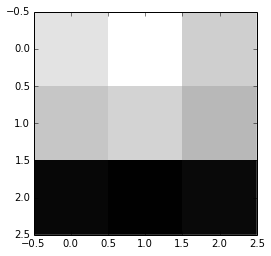

In [10]:
plt.imshow(conv1_1[0,:,:,0], interpolation='none', cmap=plt.get_cmap('gray'))

In [11]:
sess.close()